#### librerias

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from sklearn.model_selection import train_test_split

## Parte 1

La primera parte del proyecto estara centrada en la prediccion categorica de canciones, se quiere predecir si una cancion con x caracteristicas puede ser de agrado para un agente Y. Esto tratara de imitar el modelo de seleccion de canciones nuevas que plataformas como Spotify, Apple music y demas productos de streaming ofrecen al usuario como nuevas alternativas musicales o descubrimientos musicales.

La informacion fue extraida de la API de Spotify para un agente X, con el cual trataremos de hacer un modelo que nos pueda aprender la relacion entre las caracteristicas de una cancion y el gusto musical de nuestro agente X, con el fin de poder en un futuro se pueda seleccionar un grupo de canciones, pasarlar por le modelo para obtener las que le gustarian a nuestro agente X y asi poder compartirle "nuevas canciones" que seran de su agrado. 

El modelo en si es basicamente funcionara como un sistema de recomendacion.

#### Dataset

In [2]:
raw_dataset1 = pd.read_csv("parte1/data.csv", index_col=0)

El dataset consiste en un set de canciones reproducidas sobre un agente X, por cada cancion contamos con 15 features que provee spotify y la variable respuesta que indica si la cancion tuvo fue de agrado para el agente o no.

**Variables:**
* acousticness: valor entre 0 y 1 que indica que tan acustica es una cancion.
* danceability: valor entre 0 y 1 que indica que tan indicada es la cancion para bailar, esto es medido a partir del tempo, ritmo, fuerza de los tonos.
* duration_ms: Durations de la cancion en milisegundos.
* energy: valor entre 0 y 1 que mide la velocidad, lo ruidoso y el alto tono de la cancion.
* instrumentalness: valor entre 0 y 1 que mide que tan instrumental es la cancion al verificar la ausencia de sonidos vocales.
* key: la llave de la cancion.
* liveness: valor entre 0 y 1 que detenta la presencia de audiencia en la cancion.
* loudness: valor entre -60 y 0 que mide los decibeles de volumen de la cancion.
* mode: entero entre 0 y 1 que indica la modalidad (mayor o menor) de una cancion basado en que tipo de escala es derivada la cancion.
* speechiness: valor entre 0 y 1 que detecta la presencia de palabras en la cancion.
* tempo: indica el tempo estimado de toda la cancion en tonos por minuto.
* time_signature: indica cuantos tonos hay en una barra.
* valence: valor entre 0 y 1 para describir la positividad de la cancion.
* song_title: nombre de la cancion
* artist: nombre del artista de la cancion

**Variable Respuesta:**
* target: Indica con 1 si tuvo like y 0 si no.

In [3]:
raw_dataset1.head(5)

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


In [4]:
raw_dataset1.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'target',
       'song_title', 'artist'],
      dtype='object')

Debido a que el dataset contiene variables identificadoras, estas seran eliminadas y ya que es un dataset que se obtuvo a traves del API de spotify las variables categoricas ya han sido convertidas a numericas, siendo estas representadas por numeros enteros. A continuacion se hara el split entre los conjuntos de entrenamiento y de prueba.

In [5]:
dataset1 = raw_dataset1[['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'target']]

In [6]:
train, test_validation = train_test_split(dataset1, test_size=0.6, random_state=42)
test, validation = train_test_split(test_validation, test_size=0.5, random_state=42)

train_ds = torch.utils.data.TensorDataset(torch.tensor(train.drop('target', axis=1).values.astype(np.float32)), 
                                       torch.tensor(train['target'].values.astype(np.float32)))

test_ds = torch.utils.data.TensorDataset(torch.tensor(test.drop('target', axis=1).values.astype(np.float32)), 
                                       torch.tensor(test['target'].values.astype(np.float32)))

validation_ds = torch.utils.data.TensorDataset(torch.tensor(validation.drop('target', axis=1).values.astype(np.float32)), 
                                       torch.tensor(validation['target'].values.astype(np.float32)))
# dataset1_features = torch.tensor(dataset1.drop('target', axis=1).values.astype(np.float32))
# dataset1_target = torch.tensor(dataset1['target'].values.astype(np.float32))

# dataset1_tensor = torch.utils.data.TensorDataset(dataset1_features, dataset1_target)

# tp, te, vp = int(dataset1.shape[0] * 0.6), int(dataset1.shape[0] * 0.2), int(dataset1.shape[0] * 0.2) + 1
# train, test_validation = torch.utils.data.random_split(dataset1_tensor, [tp, te + vp], generator=torch.Generator().manual_seed(42))
# test, validation = torch.utils.data.random_split(test_validation, [te,vp], generator=torch.Generator().manual_seed(42))

## Experimentacion

In [7]:
def train(model, train, test, batch_size, lr, optimizer, loss_fn, epochs, description, verbose=10):
    model = model()
    loss_fn = loss_fn()
    optimizer = optimizer(model.parameters(), lr=lr)        
    train_dataloader = DataLoader(train_ds, batch_size=batch_size)
    test_dataloader = DataLoader(test_ds, batch_size=batch_size)
    
    
    losses = []
    accs = []
    for t in range(epochs):
        for batch, (X, y) in enumerate(train_dataloader):
            pred = model(X)
            loss = loss_fn(pred, y.reshape(-1, 1))
            acc = model.acc_calc(pred, y.reshape(-1, 1))

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        test_acc = model.test(test_dataloader)
        losses.append(loss.item())
        accs.append(test_acc.item())

        if t % verbose == 0:
            print(f"Epoch {t+1}\n-------------------------------")
            print(f"loss: {loss:>7f} | accuracy: {acc:>2f} | validation_accuracy: {test_acc: >2f}")
    print("Done!")
    
    # Saving the model
    torch.save(model.state_dict(), f'./parte1/experiments/{description}_batch={batch_size}_lr={str(lr)[2:]}_epochs={epochs}.pth')
            
    # Returning losses and accuracy metrics through training 
    return losses, accs

#### Arquitectura 1

In [8]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.layer_1 = nn.Linear(12, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        
        torch.nn.init.xavier_uniform_(self.layer_1.weight)
        torch.nn.init.zeros_(self.layer_1.bias)
        torch.nn.init.xavier_uniform_(self.layer_2.weight)
        torch.nn.init.zeros_(self.layer_2.bias)
        torch.nn.init.xavier_uniform_(self.layer_out.weight)
        torch.nn.init.zeros_(self.layer_out.bias)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x
    
    def acc_calc(self, y_pred, y_test):
        y_pred_tag = torch.round(torch.sigmoid(y_pred))
        correct_results_sum = (y_pred_tag == y_test).sum().float()
        acc = correct_results_sum/y_test.shape[0]
        return acc * 100
    
    def test(self, dataloader):
        correct = 0
        with torch.no_grad():
            for batch, (X, y) in enumerate(dataloader):
                pred = self.forward(X)
                pred = torch.round(torch.sigmoid(pred))
                correct += (pred == y.reshape((-1,1))).sum().float()
            return correct / len(dataloader.dataset) * 100

Epoch 1
-------------------------------
loss: 23528.919922 | accuracy: 47.368423 | validation_accuracy: 53.719009
Epoch 11
-------------------------------
loss: 3846.486328 | accuracy: 55.263157 | validation_accuracy: 48.264462
Epoch 21
-------------------------------
loss: 3011.219482 | accuracy: 55.263157 | validation_accuracy: 50.247932
Epoch 31
-------------------------------
loss: 2605.778809 | accuracy: 55.263157 | validation_accuracy: 52.231407
Epoch 41
-------------------------------
loss: 2731.959229 | accuracy: 50.000000 | validation_accuracy: 49.256199
Epoch 51
-------------------------------
loss: 1320.422485 | accuracy: 50.000000 | validation_accuracy: 47.768597
Epoch 61
-------------------------------
loss: 1047.363037 | accuracy: 57.894737 | validation_accuracy: 49.586777
Epoch 71
-------------------------------
loss: 838.713562 | accuracy: 55.263157 | validation_accuracy: 50.578510
Epoch 81
-------------------------------
loss: 482.776459 | accuracy: 47.368423 | validat

Text(0, 0.5, 'accuracy')

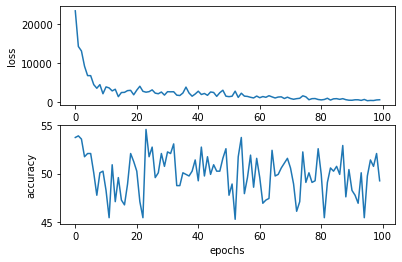

In [32]:
losses, accs = train(NN, train_ds, test_ds, 64, 0.0001, 
                      torch.optim.Adam, nn.BCEWithLogitsLoss, 100, 
                     'NN_relu_drop_out_xavier', 10)

f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

Epoch 1
-------------------------------
loss: 2352.200928 | accuracy: 60.526318 | validation_accuracy: 50.578510
Epoch 11
-------------------------------
loss: 621.044434 | accuracy: 44.736843 | validation_accuracy: 53.223141
Epoch 21
-------------------------------
loss: 75.692680 | accuracy: 42.105263 | validation_accuracy: 53.553719
Epoch 31
-------------------------------
loss: 2.977026 | accuracy: 47.368423 | validation_accuracy: 46.280991
Epoch 41
-------------------------------
loss: 2.097493 | accuracy: 52.631580 | validation_accuracy: 53.719009
Epoch 51
-------------------------------
loss: 1.192698 | accuracy: 47.368423 | validation_accuracy: 53.719009
Epoch 61
-------------------------------
loss: 1.773133 | accuracy: 44.736843 | validation_accuracy: 46.280991
Epoch 71
-------------------------------
loss: 0.711860 | accuracy: 50.000000 | validation_accuracy: 45.785122
Epoch 81
-------------------------------
loss: 0.737468 | accuracy: 57.894737 | validation_accuracy: 46.446

Text(0, 0.5, 'accuracy')

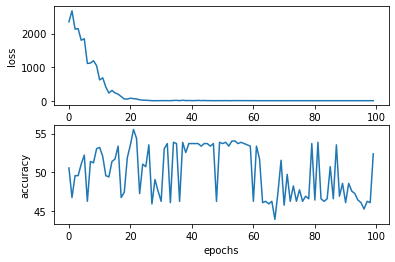

In [33]:
losses, accs = train(NN, train_ds, test_ds, 64, 0.001, 
                      torch.optim.Adam, nn.BCEWithLogitsLoss, 100, 
                     'NN_relu_drop_out_xavier', 10)

f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

Epoch 1
-------------------------------
loss: 11263.225586 | accuracy: 57.894737 | validation_accuracy: 46.942146
Epoch 11
-------------------------------
loss: 8904.163086 | accuracy: 60.526318 | validation_accuracy: 47.272728
Epoch 21
-------------------------------
loss: 7127.978027 | accuracy: 57.894737 | validation_accuracy: 48.595039
Epoch 31
-------------------------------
loss: 6493.575195 | accuracy: 50.000000 | validation_accuracy: 45.454548
Epoch 41
-------------------------------
loss: 2879.329834 | accuracy: 55.263157 | validation_accuracy: 48.429752
Epoch 51
-------------------------------
loss: 5930.879395 | accuracy: 44.736843 | validation_accuracy: 49.421486
Epoch 61
-------------------------------
loss: 4172.462402 | accuracy: 52.631580 | validation_accuracy: 47.768597
Epoch 71
-------------------------------
loss: 4266.201660 | accuracy: 50.000000 | validation_accuracy: 51.735538
Epoch 81
-------------------------------
loss: 3090.697021 | accuracy: 57.894737 | valid

Text(0, 0.5, 'accuracy')

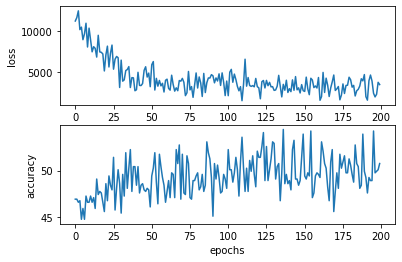

In [35]:
losses, accs = train(NN, train_ds, test_ds, 128, 0.00001, 
                      torch.optim.Adam, nn.BCEWithLogitsLoss, 200, 
                     'NN_relu_drop_out_xavier', 10)

f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

Epoch 1
-------------------------------
loss: 5870.195801 | accuracy: 44.736843 | validation_accuracy: 54.876034
Epoch 11
-------------------------------
loss: 2764.093018 | accuracy: 44.736843 | validation_accuracy: 54.380165
Epoch 21
-------------------------------
loss: 2912.361328 | accuracy: 55.263157 | validation_accuracy: 54.545456
Epoch 31
-------------------------------
loss: 2596.621826 | accuracy: 55.263157 | validation_accuracy: 49.586777
Epoch 41
-------------------------------
loss: 2147.195312 | accuracy: 52.631580 | validation_accuracy: 49.421486
Epoch 51
-------------------------------
loss: 3471.816162 | accuracy: 42.105263 | validation_accuracy: 47.768597
Epoch 61
-------------------------------
loss: 2704.407959 | accuracy: 55.263157 | validation_accuracy: 50.578510
Epoch 71
-------------------------------
loss: 1744.886719 | accuracy: 57.894737 | validation_accuracy: 49.752064
Epoch 81
-------------------------------
loss: 2147.778076 | accuracy: 60.526318 | valida

Text(0, 0.5, 'accuracy')

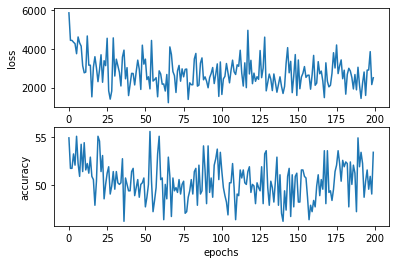

In [37]:
losses, accs = train(NN, train_ds, test_ds, 128, 0.00001, 
                      torch.optim.Adamax, nn.BCEWithLogitsLoss, 200, 
                     'NN_relu_drop_out_xavier', 10)

f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

### Arquitectura 2

In [38]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.layer_1 = nn.Linear(12, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
        torch.nn.init.xavier_uniform_(self.layer_1.weight)
        torch.nn.init.zeros_(self.layer_1.bias)
        torch.nn.init.xavier_uniform_(self.layer_2.weight)
        torch.nn.init.zeros_(self.layer_2.bias)
        torch.nn.init.xavier_uniform_(self.layer_out.weight)
        torch.nn.init.zeros_(self.layer_out.bias)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x
    
    def acc_calc(self, y_pred, y_test):
        y_pred_tag = torch.round(torch.sigmoid(y_pred))
        correct_results_sum = (y_pred_tag == y_test).sum().float()
        acc = correct_results_sum/y_test.shape[0]
        return acc * 100
    
    def test(self, dataloader):
        correct = 0
        with torch.no_grad():
            for batch, (X, y) in enumerate(dataloader):
                pred = self.forward(X)
                pred = torch.round(torch.sigmoid(pred))
                correct += (pred == y.reshape((-1,1))).sum().float()
            return correct / len(dataloader.dataset) * 100

Epoch 1
-------------------------------
loss: 0.719520 | accuracy: 57.894737 | validation_accuracy: 57.024796
Epoch 11
-------------------------------
loss: 0.676610 | accuracy: 55.263157 | validation_accuracy: 56.528927
Epoch 21
-------------------------------
loss: 0.711928 | accuracy: 52.631580 | validation_accuracy: 56.859505
Epoch 31
-------------------------------
loss: 0.663516 | accuracy: 52.631580 | validation_accuracy: 55.702477
Epoch 41
-------------------------------
loss: 0.692554 | accuracy: 44.736843 | validation_accuracy: 55.702477
Epoch 51
-------------------------------
loss: 0.613007 | accuracy: 60.526318 | validation_accuracy: 58.347107
Epoch 61
-------------------------------
loss: 0.679011 | accuracy: 50.000000 | validation_accuracy: 54.545456
Epoch 71
-------------------------------
loss: 0.654728 | accuracy: 63.157890 | validation_accuracy: 55.371899
Epoch 81
-------------------------------
loss: 0.677197 | accuracy: 60.526318 | validation_accuracy: 56.694214
Ep

Text(0, 0.5, 'accuracy')

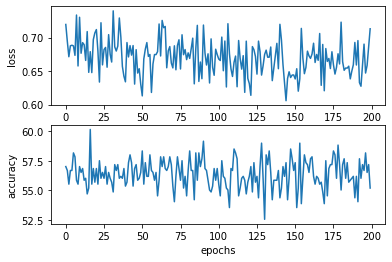

In [41]:
losses, accs = train(NN, train_ds, test_ds, 128, 0.00001, 
                      torch.optim.Adamax, nn.BCEWithLogitsLoss, 200, 
                     'NN_relu_drop_out_batchnorm_xavier', 10)

f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

Epoch 1
-------------------------------
loss: 0.646617 | accuracy: 57.894737 | validation_accuracy: 54.876034
Epoch 21
-------------------------------
loss: 0.649045 | accuracy: 63.157890 | validation_accuracy: 55.702477
Epoch 41
-------------------------------
loss: 0.652843 | accuracy: 55.263157 | validation_accuracy: 56.859505
Epoch 61
-------------------------------
loss: 0.669040 | accuracy: 63.157890 | validation_accuracy: 56.363636
Epoch 81
-------------------------------
loss: 0.653913 | accuracy: 60.526318 | validation_accuracy: 56.528927
Epoch 101
-------------------------------
loss: 0.679167 | accuracy: 52.631580 | validation_accuracy: 56.859505
Epoch 121
-------------------------------
loss: 0.713814 | accuracy: 50.000000 | validation_accuracy: 57.520664
Epoch 141
-------------------------------
loss: 0.652608 | accuracy: 57.894737 | validation_accuracy: 56.033058
Epoch 161
-------------------------------
loss: 0.657146 | accuracy: 60.526318 | validation_accuracy: 57.85123

Text(0, 0.5, 'accuracy')

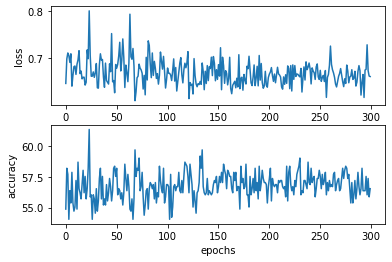

In [42]:
losses, accs = train(NN, train_ds, test_ds, 128, 0.001, 
                      torch.optim.Adam, nn.BCEWithLogitsLoss, 300, 
                     'NN_relu_drop_out_batchnorm_xavier', 20)

f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

In [ ]:
losses, accs = train(NN, train_ds, test_ds, 128, 0.00001, 
                      torch.optim.Adamax, nn.BCEWithLogitsLoss, 200, 
                     'NN_relu_drop_out_xavier', 10)

f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

#### Validation

In [ ]:
ld = NN()
ld.load_state_dict(torch.load("./parte1/experiments/NN_relu_drop_out_xavier_batch=64_lr=0001_epochs=100.pth"))
ld.test(DataLoader(test_ds, batch_size=))

#### Conclusiones

## Parte 2

#### Dataset

#### Definicion arquitectura

#### Experimentacion

#### Conclusiones

## Parte 3

#### Dataset

#### Definicion arquitectura

#### Experimentacion

#### Conclusiones